In [1]:
import pandas as pd
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6225750709107930252
xla_global_id: -1
]


Dataset information
Import Medium-articles-dataset:

This dataset contains information about randomly chosen medium articles published in 2019 from these 7 publications:

Towards Data Science
UX Collective
The Startup
The Writing Cooperative
Data Driven Investor
Better Humans
Better Marketing

In [8]:
medium_data = pd.read_csv(r'D:\NLP\NLP Diploma Shaai For AI Using Pytourch\nlp-course-notebooks-master\nextword/medium_data.csv')
medium_data.head()

,id,url,title,subtitle,image,claps,responses,reading_time,publication,date
0,1,https://towardsdatascience.com/a-beginners-gui...,A Beginner’s Guide to Word Embedding with Gens...,NaN,1.png,850,8,8,Towards Data Science,2019-05-30
1,2,https://towardsdatascience.com/hands-on-graph-...,Hands-on Graph Neural Networks with PyTorch & ...,NaN,2.png,1100,11,9,Towards Data Science,2019-05-30
2,3,https://towardsdatascience.com/how-to-use-ggpl...,How to Use ggplot2 in Python,A Grammar of Graphics for Python,3.png,767,1,5,Towards Data Science,2019-05-30
3,4,https://towardsdatascience.com/databricks-how-...,Databricks: How to Save Files in CSV on Your L...,When I work on Python projects dealing…,4.jpeg,354,0,4,Towards Data Science,2019-05-30
4,5,https://towardsdatascience.com/a-step-by-step-...,A Step-by-Step Implementation of Gradient Desc...,One example of building neural…,5.jpeg,211,3,4,Towards Data Science,2019-05-30


In [9]:
print("Number of records: ", medium_data.shape[0])
print("Number of fields: ", medium_data.shape[1])

Number of records:  6508
Number of fields:  10


Display titles of various articles and preprocess them

In [10]:
medium_data['title']

0       A Beginner’s Guide to Word Embedding with Gens...
1       Hands-on Graph Neural Networks with PyTorch & ...
2                            How to Use ggplot2 in Python
3       Databricks: How to Save Files in CSV on Your L...
4       A Step-by-Step Implementation of Gradient Desc...
                              ...                        
6503    “We” vs “I” — How Should You Talk About Yourse...
6504                     How Donald Trump Markets Himself
6505        Content and Marketing Beyond Mass Consumption
6506    5 Questions All Copywriters Should Ask Clients...
6507               How To Write a Good Business Blog Post
Name: title, Length: 6508, dtype: object

Removing unwanted characters and words in titles
Looking at titles, we can see there are some of unwanted characters and words in it which can not be useful for us to predict infact it might decrease our model accuracy so we have to remove it.

In [11]:
medium_data['title'] = medium_data['title'].apply(lambda x: x.replace(u'\xa0',u' '))
medium_data['title'] = medium_data['title'].apply(lambda x: x.replace('\u200a',' '))

Tokenzation
Tokenzaion is the process in which we provide an unique id to all the words and make a word index or we can say vocabulary.

In [12]:
tokenizer = Tokenizer(oov_token='<oov>') # For those words which are not found in word_index
tokenizer.fit_on_texts(medium_data['title'])
total_words = len(tokenizer.word_index) + 1

print("Total number of words: ", total_words)
print("Word: ID")
print("------------")
print("<oov>: ", tokenizer.word_index['<oov>'])
print("Strong: ", tokenizer.word_index['strong'])
print("And: ", tokenizer.word_index['and'])
print("Consumption: ", tokenizer.word_index['consumption'])

Total number of words:  8238
Word: ID
------------
<oov>:  1
Strong:  4
And:  8
Consumption:  8237


Titles text into sequences and make n_gram mode

In [13]:
input_sequences = []
for line in medium_data['title']:
    token_list = tokenizer.texts_to_sequences([line])[0]
    #print(token_list)
    
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

# print(input_sequences)
print("Total input sequences: ", len(input_sequences))

Total input sequences:  48461


Make all titles with same length by using padding
The length of every title has to be the same. To make it, we need to find a title that has a maximum length, and based on that length, we have to pad rest of titles.

In [14]:
# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
input_sequences[1]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   5, 676,
        68])

Prepare features and labels
Here, we consider last element of all sequences as a label.Then, We need to perform onehot encoding on labels corresponding to total_words.

In [15]:
# create features and label
xs, labels = input_sequences[:,:-1],input_sequences[:,-1]
ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [16]:
print(xs[5])
print(labels[5])
print(ys[5][14])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    5  676   68    2  452 1518]
14
1.0


Architechture of Bidirectional LSTM Neural Network

In [19]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150)))
model.add(Dense(total_words, activation='softmax'))
adam = Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
history = model.fit(xs, ys, epochs=10, verbose=1)
#print model.summary()
print(model)

Epoch 1/10
1515/1515 [==============================] - 127s 82ms/step - loss: 6.7744 - accuracy: 0.1258
Epoch 2/10
1515/1515 [==============================] - 127s 84ms/step - loss: 5.7752 - accuracy: 0.1762
Epoch 3/10
1515/1515 [==============================] - 122s 80ms/step - loss: 4.9530 - accuracy: 0.2044
Epoch 4/10
1515/1515 [==============================] - 121s 80ms/step - loss: 4.2055 - accuracy: 0.2471
Epoch 5/10
1515/1515 [==============================] - 118s 78ms/step - loss: 3.6468 - accuracy: 0.3006
Epoch 6/10
1515/1515 [==============================] - 120s 79ms/step - loss: 3.2825 - accuracy: 0.3380
Epoch 7/10
1515/1515 [==============================] - 121s 80ms/step - loss: 3.0115 - accuracy: 0.3710
Epoch 8/10
1515/1515 [==============================] - 120s 79ms/step - loss: 2.8422 - accuracy: 0.3919
Epoch 9/10
1515/1515 [==============================] - 121s 80ms/step - loss: 2.7427 - accuracy: 0.4061
Epoch 10/10
1515/1515 [==============================] 

Plotting model accuracy and loss

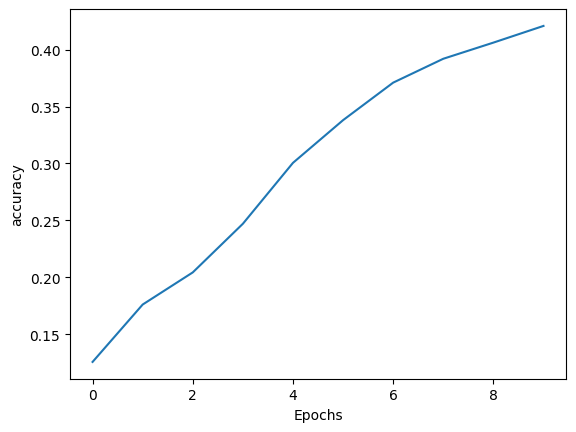

In [20]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.show()
plot_graphs(history, 'accuracy')

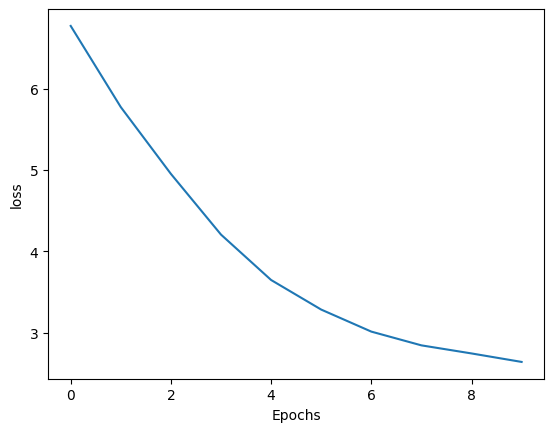

In [21]:
plot_graphs(history, 'loss')

Predicting next word of title

In [26]:
seed_text = "How i"
next_words = 2

for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted_probabilities = model.predict(token_list, verbose=0)
    predicted_word_index = tf.argmax(predicted_probabilities, axis=-1).numpy()[0]
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted_word_index:
            output_word = word
            break
    seed_text += " " + output_word

print(seed_text)


How i trained computer
